#### Smart Home Data [source](https://www.kaggle.com/code/offmann/smart-home-dataset/input)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv("data/HomeC.csv")
df.head()

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\2645709189.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/HomeC.csv")


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [63]:
# inspect missingness

df.isna().sum().sort_values(ascending=False).head(1)

use [kW]    1
dtype: int64

In [64]:
df.shape

(503911, 32)

In [65]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

#### Data preprocessing

In [66]:
# Rename columns to remove spaces and the kW unit 
df.columns = [col[:-5].replace(' ','_') if 'kW' in col else col for col in df.columns]

# Drop rows with nan values 
df = df.dropna()

# The columns "use" and "house_overall" are the same, so let's remove the 'house_overall' column
df.drop(['House_overall'], axis=1, inplace=True)

# The columns "gen" and "solar" are the same, so let's remove the 'solar' column
df.drop(['Solar'], axis=1, inplace=True)

# drop rows with cloudCover column values that are not numeric (bug in sensors) and convert column to numeric
df = df[df['cloudCover']!='cloudCover']
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

# Create columns that regroup kitchens and furnaces 
df['kitchen'] = df['Kitchen_12'] + df['Kitchen_14'] + df['Kitchen_38']
df['Furnace'] = df['Furnace_1'] + df['Furnace_2']

# Convert "time" column (which is a unix timestamp) to a Y-m-d H-M-S 
import time 
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df['time'].iloc[0])))
time_index = pd.date_range(start_time, periods=len(df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

In [67]:
# Helpful functions

# lower first letter of a string  
func = lambda s: s[:1].lower() + s[1:] if s else ''

# Remove rows with values that appear less than a certain percentage %
def remove_less_percent(col, percent):
    keys_to_conserve = [key for key,value in df[col].value_counts(normalize=True).items() if value>=percent]
    return df[df[col].isin(keys_to_conserve)]


In [68]:
cols = list(df.dtypes.keys())
categ_cols = [col for col in cols if df[col].dtype=='O']
num_cols = [col for col in cols if col not in categ_cols]
print('categ_cols : ', categ_cols)
print('num_cols : ', num_cols)

categ_cols :  ['icon', 'summary']
num_cols :  ['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office', 'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14', 'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'kitchen', 'Furnace']


In [69]:
print(len(df))
df = remove_less_percent('summary', 0.05)
print(len(df))
df = remove_less_percent('icon', 0.05)
print(len(df))

503852
466308
466308


In [70]:
# Keep a copy of original, cleaned df

full = df.copy()

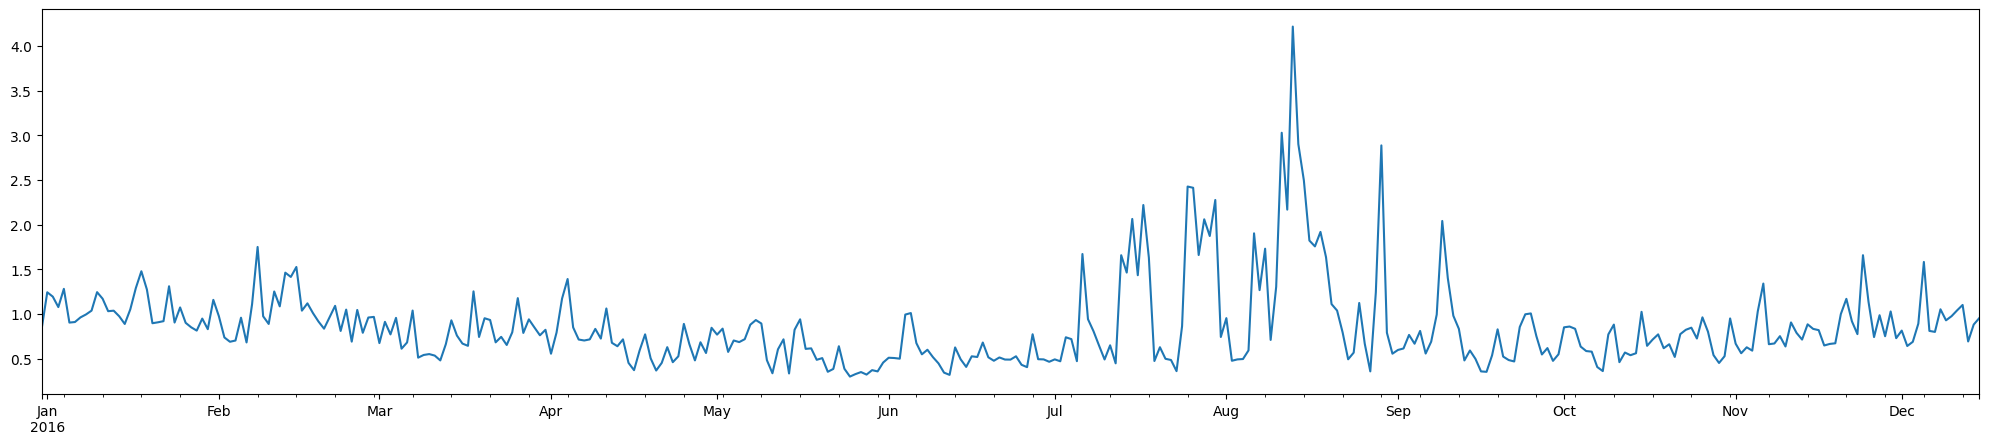

In [71]:
# plot use intensity by day, rolling daily average

use = df['use'].resample(rule='D').mean().plot(figsize=(25,5));

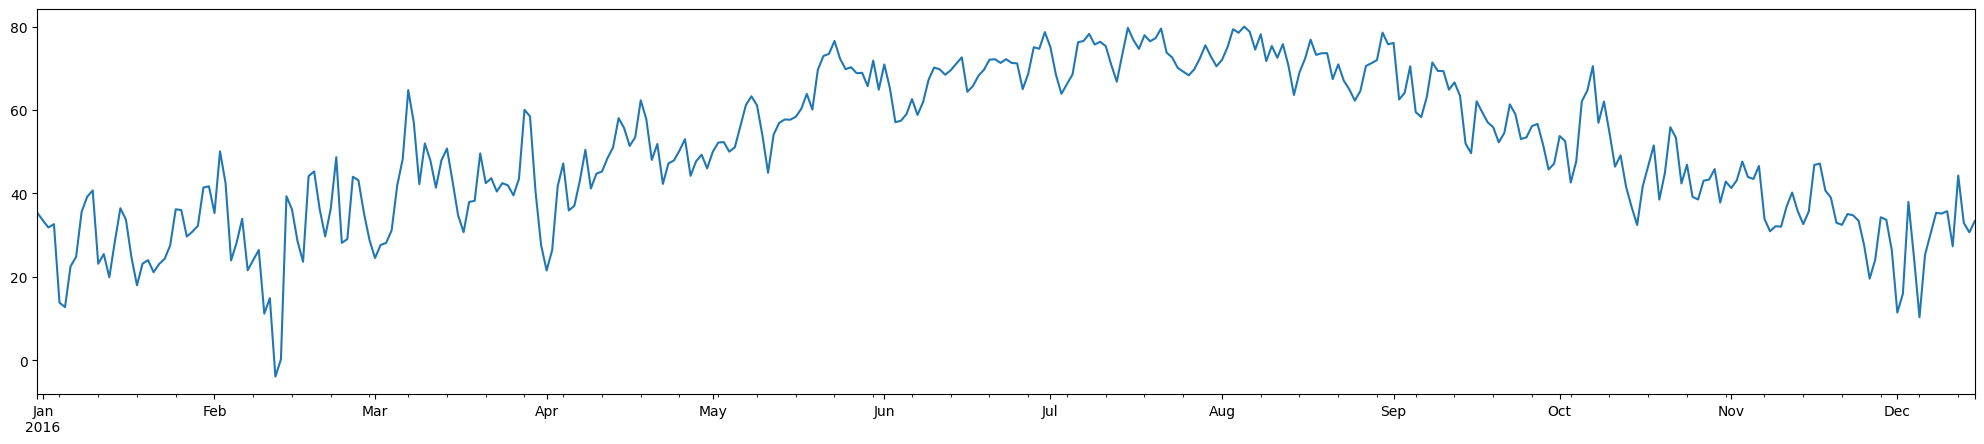

In [72]:
# plot temperature by day, rolling daily average

temp = df['temperature'].resample(rule='D').mean().plot(figsize=(25,5));

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\3719703798.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gen = df['gen'].resample(rule='M').mean().plot(figsize=(25,5));


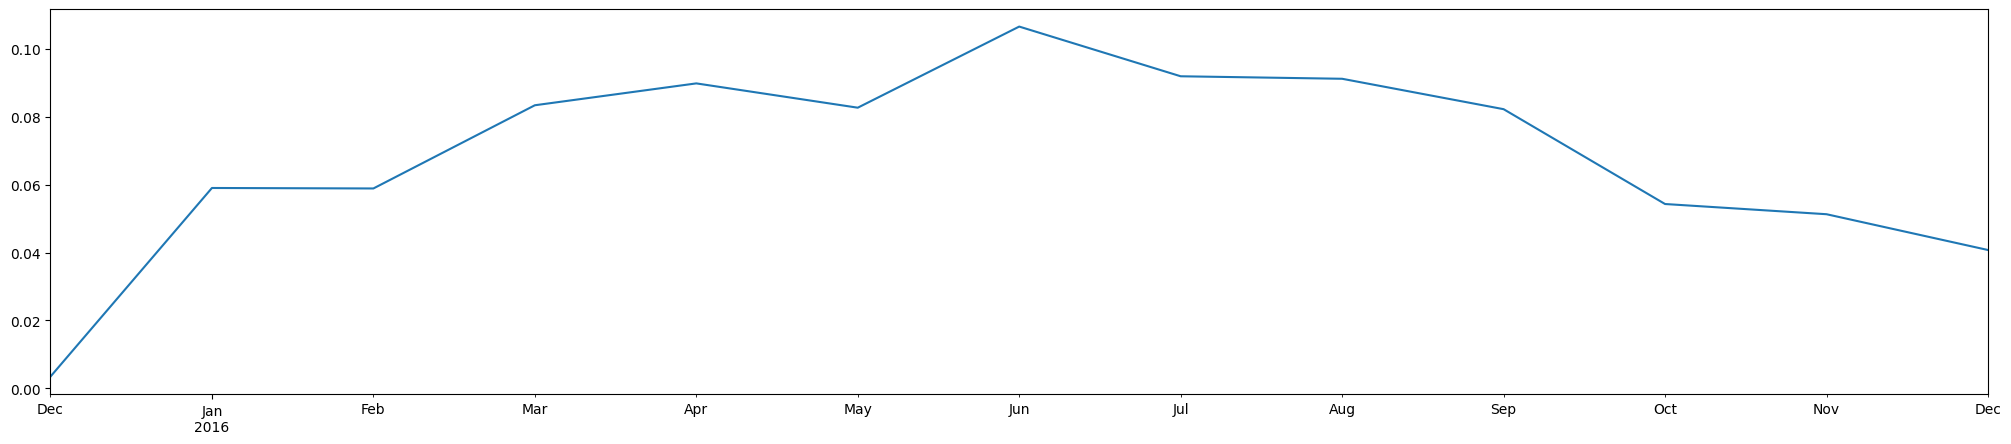

In [73]:
# plot renewable generation by month, rolling monthly average

gen = df['gen'].resample(rule='M').mean().plot(figsize=(25,5));

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\2117852713.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rooms_energy_per_month = df[rooms_energy_cols].resample('M').mean()


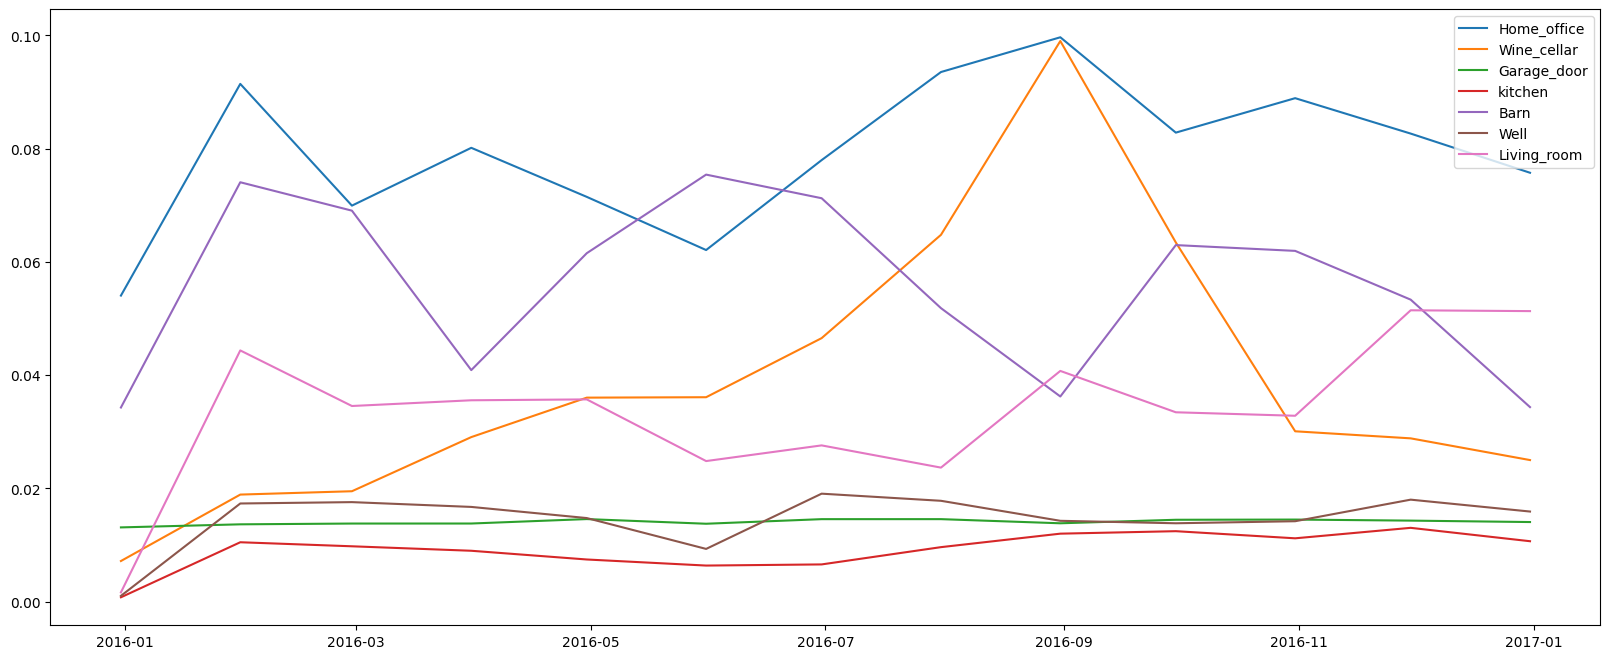

In [74]:
# plot room energy by month, rolling monthly average

rooms_energy_cols = ['Home_office', 'Wine_cellar','Garage_door',
                       'kitchen', 'Barn', 'Well','Living_room']

rooms_energy_per_month = df[rooms_energy_cols].resample('M').mean()   

plt.figure(figsize=(20,8))

room = sns.lineplot(data=rooms_energy_per_month, dashes=False);

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\564968917.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  equipments_energy_per_month = df[equipments_cols].resample('M').mean()


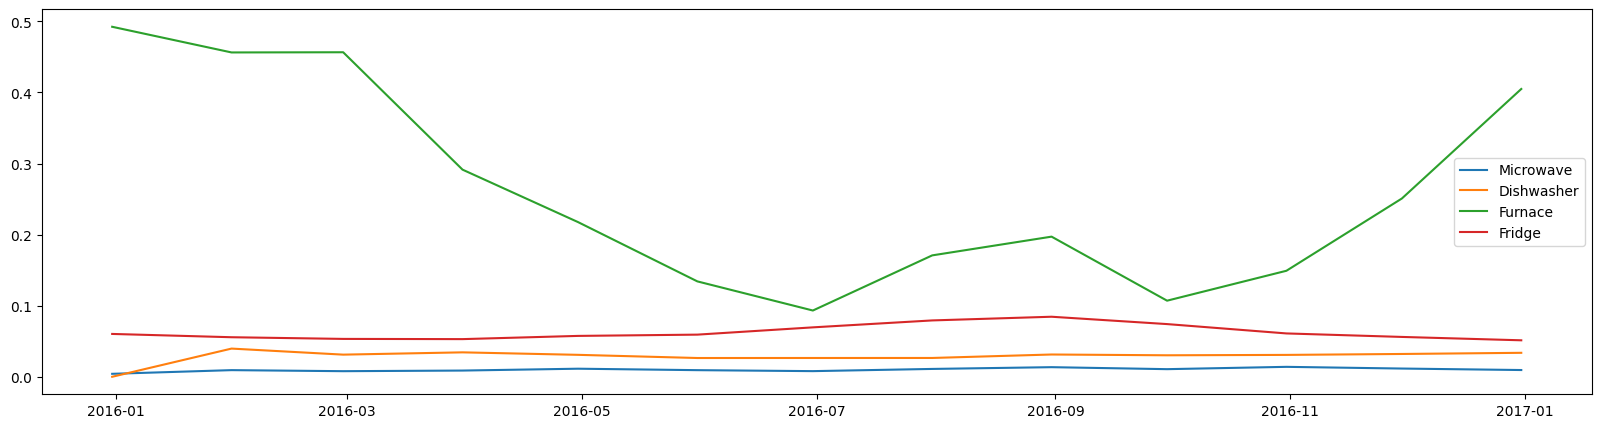

In [75]:
# plot equipment energy use by month, rolling monthly average

equipments_cols = ['Microwave', 'Dishwasher', 'Furnace', 'Fridge'] 

equipments_energy_per_month = df[equipments_cols].resample('M').mean()   

plt.figure(figsize=(20,5))

equip = sns.lineplot(data= equipments_energy_per_month, dashes=False);

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\1912056898.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather_per_month = df[weather_columns].resample('M').mean()


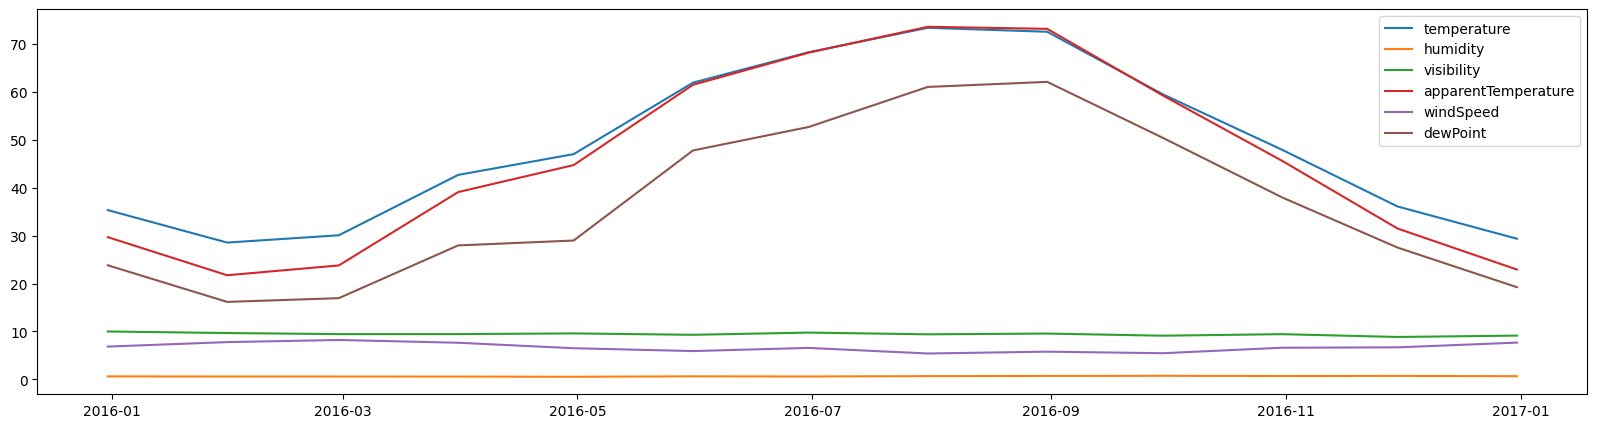

In [76]:
# plot weather by month, rolling monthly average

weather_columns = ['temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']

weather_per_month = df[weather_columns].resample('M').mean()   

plt.figure(figsize=(20,5))

weather = sns.lineplot(data=weather_per_month, dashes=False); 

#### Problem:  

1. Change Detection : Detecting excessive energy consumption in advance and preventing increase in usage fees.

1. Utility Bill Explanation : Segment systems using energy to identify source(s) of bill increases and pain points.

1. <i>(unpreferred but is an option)</i> Predict Future Consumption : Predicting future energy consumption and generation by utilizing weather information and optimizing energy supply.

#### Testing ways to let LLM read and understand tabular data

In [77]:
df = df[[col for col in  df.columns if col not in ['icon', 'summary']]]

In [78]:
df.resample(rule='ME').mean()

,use,gen,Dishwasher,Furnace_1,Furnace_2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen_12,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,kitchen,Furnace
2015-12-31,0.836898,0.003448,0.000091,0.238546,0.253805,0.054039,0.060343,0.007168,0.013105,0.000596,...,29.688033,1016.016885,6.847049,0.750000,272.606557,0.000000,23.812787,0.000000,0.000765,0.492352
2016-01-31,1.047812,0.059034,0.039739,0.221878,0.234376,0.091420,0.055713,0.018900,0.013647,0.002872,...,21.736173,1015.090114,7.783113,0.153052,220.376512,0.000587,16.175059,0.013582,0.010482,0.456255
2016-02-29,0.995173,0.058891,0.031232,0.222302,0.234220,0.069926,0.053357,0.019491,0.013786,0.002907,...,23.781804,1016.208478,8.225271,0.184758,228.623270,0.001739,16.954383,0.045239,0.009769,0.456522
2016-03-31,0.770586,0.083415,0.034448,0.118393,0.173024,0.080134,0.053053,0.029050,0.013790,0.000656,...,39.091757,1015.846088,7.646526,0.196828,198.988810,0.001714,27.959354,0.053445,0.008979,0.291417
2016-04-30,0.690589,0.089860,0.030955,0.094915,0.122734,0.071471,0.057580,0.036019,0.014573,0.000613,...,44.726490,1018.146394,6.505913,0.233695,184.450862,0.001501,28.982547,0.039322,0.007438,0.217649
2016-05-31,0.570911,0.082698,0.026486,0.048589,0.085656,0.062082,0.059366,0.036092,0.013750,0.000808,...,61.482092,1014.778717,5.914464,0.216443,183.697951,0.001844,47.778666,0.047436,0.006366,0.134245
2016-06-30,0.537512,0.106605,0.026522,0.025971,0.067307,0.077959,0.069597,0.046525,0.014561,0.000836,...,68.181859,1012.736308,6.572146,0.133897,226.678634,0.000977,52.665634,0.026636,0.006568,0.093277
2016-07-31,1.165928,0.091958,0.026554,0.060952,0.109885,0.093516,0.079352,0.064768,0.014563,0.002790,...,73.589111,1014.796305,5.405723,0.185565,202.500718,0.001704,61.036282,0.048117,0.009618,0.170838
2016-08-31,1.400862,0.091221,0.031419,0.069776,0.127411,0.099653,0.084534,0.098990,0.013831,0.004962,...,73.157331,1017.355698,5.787911,0.146087,183.234713,0.001345,62.090030,0.037913,0.011999,0.197187
2016-09-30,0.722752,0.082260,0.030318,0.030985,0.076128,0.082817,0.074198,0.063424,0.014452,0.005606,...,59.272545,1021.932027,5.461396,0.204657,168.658955,0.001285,50.427411,0.037808,0.012437,0.107113


In [79]:
pd.to_datetime('01-01-2016')

Timestamp('2016-01-01 00:00:00')

In [80]:
# sanity check

test = df.copy()
test.reset_index(inplace=True)
test.rename(columns={'index': 'timestamp'}, inplace=True)
test[test.timestamp < pd.to_datetime('01-01-2016')]['use'].mean()

np.float64(0.8368982240327868)

In [81]:
print(df.resample(rule='Me').mean().to_string())

                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room  temperature  humidity  visibility  apparentTemperature     pressure  windSpeed  cloudCover  windBearing  precipIntensity   dewPoint  precipProbability   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013105    0.000596    0.000156    0.000014  0.034275  0.001016   0.004256     0.001633    35.333115  0.625738   10.000000            29.688033  1016.016885   6.847049    0.750000   272.606557         0.000000  23.812787           0.000000  0.000765  0.492352
2016-01-31  1.047812  0.059034    0.039739   0.221878   0.234376     0.091420  0.055713     0.018900     0.013647    0.002872    0.007600    0.000010  0.074052  0.017327   0.009432     0.044356    28.553342  0.607230    9.675395            21.736173  1015.090114   7.7

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\2524405646.py:1: FutureWarning: 'Me' is deprecated and will be removed in a future version, please use 'ME' instead.
  print(df.resample(rule='Me').mean().to_string())


In [82]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office',
       'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14',
       'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature',
       'humidity', 'visibility', 'apparentTemperature', 'pressure',
       'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'kitchen', 'Furnace'],
      dtype='object')

In [83]:
# separate columns related to energy consumption

uses = df[[col for col in df.columns if col not in weather_columns+[
    'cloudCover', 'precipIntensity', 'precipProbability', 'windBearing', 'icon', 
    'summary', 'pressure']]]

use_str = uses.resample(rule='M').mean().to_string()

print(use_str)

                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013105    0.000596    0.000156    0.000014  0.034275  0.001016   0.004256     0.001633  0.000765  0.492352
2016-01-31  1.047812  0.059034    0.039739   0.221878   0.234376     0.091420  0.055713     0.018900     0.013647    0.002872    0.007600    0.000010  0.074052  0.017327   0.009432     0.044356  0.010482  0.456255
2016-02-29  0.995173  0.058891    0.031232   0.222302   0.234220     0.069926  0.053357     0.019491     0.013786    0.002907    0.006851    0.000011  0.069036  0.017568   0.007959     0.034542  0.009769  0.456522
2016-03-31  0.770586  0.083415    0.034448   0.118393   0.173024     0.080134  0.053053     0.029050     0.013790    0.000656    0.008312    0.0

C:\Users\dangn\AppData\Local\Temp\ipykernel_15748\1766997793.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  use_str = uses.resample(rule='M').mean().to_string()


In [84]:
# prepare a sample

sample_data = df.head(10).to_csv(index=False)
print(sample_data)

use,gen,Dishwasher,Furnace_1,Furnace_2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen_12,Kitchen_14,Kitchen_38,Barn,Well,Microwave,Living_room,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,kitchen,Furnace
0.6316,0.003466667,3.33e-05,0.158883333,0.0639,0.0434,0.0825,0.009083333,0.012983333,0.000516667,5e-05,0.0,0.031766667,0.001033333,0.004083333,0.001616667,35.4,0.61,10.0,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000566667,0.22278333299999997
1.070016667,0.0035,0.000233333,0.497633333,0.0629,0.043583333,0.170883333,0.008883333,0.0125,0.00035,0.000216667,1.67e-05,0.0317,0.001083333,0.004083333,0.001683333,35.4,0.61,10.0,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000583367,0.560533333
1.01625,0.003466667,0.000216667,0.466683333,0.062766667,0.043533333,0.14955,0.0089,0.012566667,0.000416667,0.0002,1.67e-05,0.031733333,0.001016667,0.004083333,0.001683333,35.4,0.61,10.0,28.87,1015.98,8.2,0.75

In [85]:
# combine the details

data_description = f"""
The dataset contains the following columns:
{', '.join(df.columns)}

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
{use_str}

Sample data:
{sample_data}
"""

In [86]:
print(data_description)


The dataset contains the following columns:
use, gen, Dishwasher, Furnace_1, Furnace_2, Home_office, Fridge, Wine_cellar, Garage_door, Kitchen_12, Kitchen_14, Kitchen_38, Barn, Well, Microwave, Living_room, temperature, humidity, visibility, apparentTemperature, pressure, windSpeed, cloudCover, windBearing, precipIntensity, dewPoint, precipProbability, kitchen, Furnace

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013

In [87]:
# !pip install openai python-dotenv -q

In [88]:
import openai 
from dotenv import load_dotenv
import os 

load_dotenv()

GPT_MODEL = 'gpt-4o'

In [89]:
# API Configuration
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [90]:
# prepare prompt

prompt = f"""
This is a time-series dataset of utility usage for a smart home:
{data_description}

Please answer the following questions:
1. Identify any sources with an increasing trend in electricity usage over time. 
2. Highlight any significant outliers or anomalies. 
"""

In [91]:
# prepare 

messages = [
        {"role": "system", "content": 
        
        "You are a smart home utility data analyst conversing with the homeowner directly. Be precise, concise, and keep the response within a comfortable length for the homeowner to read conveniently and understand their utility usage with actionable insights to pinpoint inefficiencies."
        
        },

        {"role": "user", "content": prompt},
    ]

response = openai.chat.completions.create(
    model=GPT_MODEL, messages=messages
    )

In [92]:
print(response.choices[0].message.content)

Analyzing the provided data, here are the insights:

1. **Increasing Trend in Electricity Usage:**
   
   - **Home Office:** Notable increase from 0.054 kW in December 2015 to 0.099 kW in August 2016.
   - **Wine Cellar:** Usage jumped from 0.007 kW at the end of 2015 to a high of 0.099 kW in August 2016, reflecting substantial growth.
   - **Fridge:** While overall usage is consistent, there's a slight increase from 0.060 kW in December 2015 to 0.085 kW in August 2016.

2. **Significant Outliers or Anomalies:**

   - **Furnace Usage:** High spikes in cold months like December 2015 (Furnace_1: 0.239 kW, Furnace_2: 0.254 kW). Similarly, in December 2016, both furnace usages spiked.
   - **Kitchen:** The June 2016 data shows surprisingly low usage for the kitchen-related columns, which could warrant investigation (e.g., Kitchen_12 dramatically low in some instances).
   
**Actionable Insights:**

- **Home Office & Wine Cellar:** Review and understand recent needs or equipment additions t

#### sanity check

To identify trends and anomalies in your smart home utility usage data, I have analyzed the time-series provided. Here are my findings:

1. **Increasing Trends in Usage:**
   - **Wine Cellar:** There's a noticeable increase in energy usage in the Wine Cellar from December 2015 (0.0072 kW) to August 2016 (0.0990 kW). This suggests a potential increase in cooling requirements or operational inefficiencies.
   - **Home Office:** Usage starts at 0.0540 kW in December 2015 and peaks in August 2016 at 0.0997 kW. This trend might align with greater work-from-home demand.

2. **Significant Outliers or Anomalies:**
   - **Furnace Usage:** Particularly high in December 2015 (0.4924 kW) and December 2016 (0.4049 kW), likely due to heating needs in winter months; however, it's a notable concentration of usage.
   - **August 2016:** Total usage spikes to 1.4009 kW, significantly higher than other months. The contributing factors include increased usage in the Wine Cellar, Fridge, and Home Office. This indicates potential excess cooling or a specific occasion causing higher usage.
   - **Energy Generation:** Energy generation is consistently lower than overall usage, with small fluctuations, except notable higher generation in June 2016 (0.1066 kW), possibly indicating peak solar efficiency.

**Actionable Insights:**
- Consider inspecting and potentially upgrading the cooling system in the Wine Cellar.
- Verify if there is room for optimization in energy usage in the Home Office, especially during summer months.
- Regularly maintain and assess the Furnace to ensure peak efficiency, especially before the heating season.
- Explore potential enhancements or expansions to your energy generation system to better align with high usage periods.

By addressing these areas, you can likely reduce excess usage and improve energy efficiency in your home.

In [93]:
print(prompt)


This is a time-series dataset of utility usage for a smart home:

The dataset contains the following columns:
use, gen, Dishwasher, Furnace_1, Furnace_2, Home_office, Fridge, Wine_cellar, Garage_door, Kitchen_12, Kitchen_14, Kitchen_38, Barn, Well, Microwave, Living_room, temperature, humidity, visibility, apparentTemperature, pressure, windSpeed, cloudCover, windBearing, precipIntensity, dewPoint, precipProbability, kitchen, Furnace

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091  

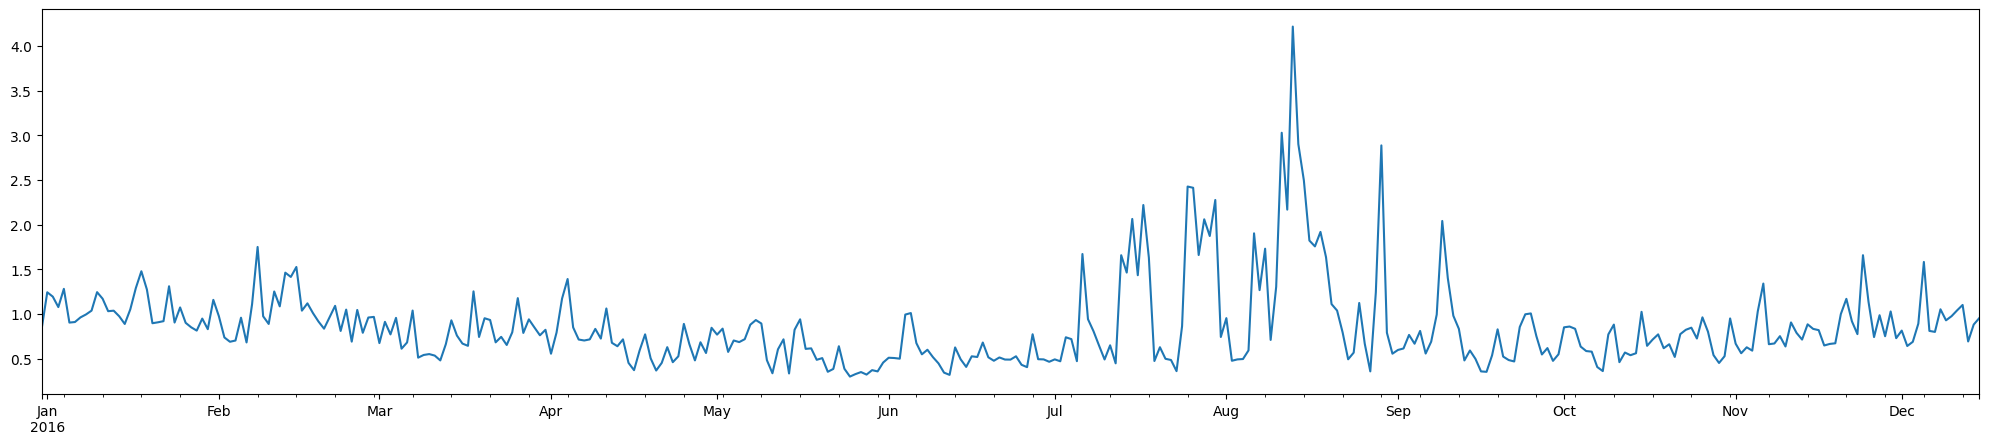

In [94]:
# check total use

use.get_figure()

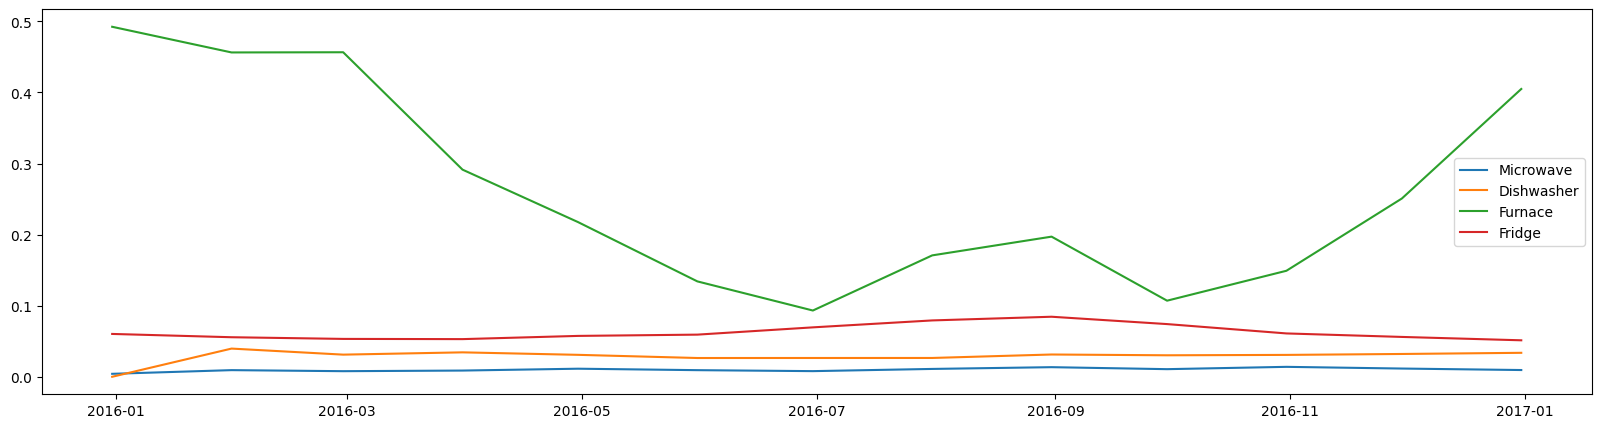

In [95]:
# check equipments 

equip.get_figure()

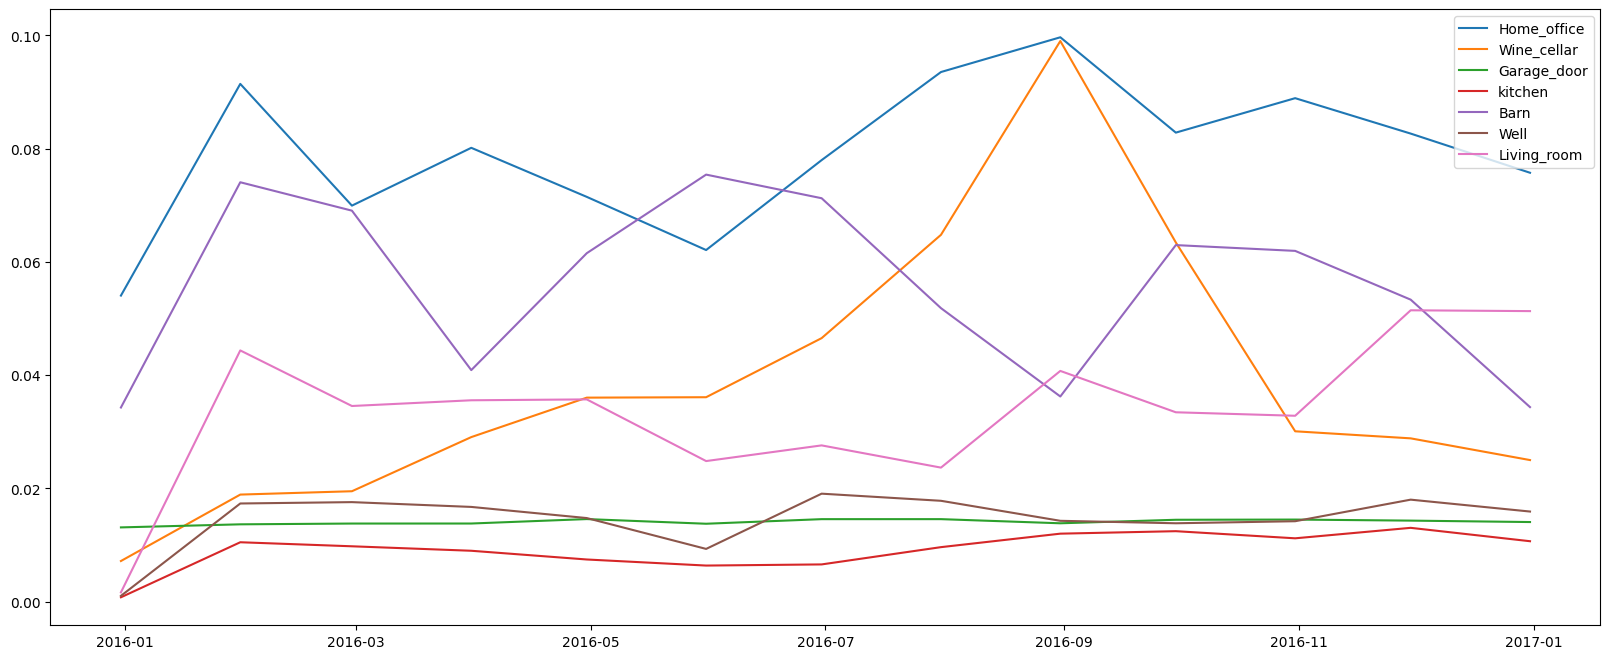

In [96]:
# check locations

room.get_figure()

In [97]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office',
       'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14',
       'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature',
       'humidity', 'visibility', 'apparentTemperature', 'pressure',
       'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'kitchen', 'Furnace'],
      dtype='object')

### Two functionalities

1. Summary report (Spotify wrapped)
1. Utility bill explanation

### Work distribution

#### Data split

OVERALL: use, gen 

APPLIANCES: dishwasher, fridge, wine cellar, microwave, garage door, furnace (sum of furnace 1 / 2) - Eric

LOCATIONS: home office, barn, well, living room, kitchen (sum kitchen 12 / 14 / 38) - Bofu

WEATHER: temperature, icon, humidity, visibility, summary, apparentTemperature, 
       pressure, windSpeed, cloudCover, windBearing, precipIntensity,
       dewPoint, precipProbability - Daniel

#### RAG split

Decode Your Power Bill (Daniel and Bofu)

Utility Price (we can assume Colorado or Lake Tahoe) (Phu and Eric)

#### Guardrail split (NeMo)

Input moderation 

RAG evaluation

Output moderation

### Development strategy

Test scenario / guardrail formation (5 each)
1. Peform EDA to figure out an exact answer to a specific user prompt (ex: Furnace_2 used most energy, on average, in Dec 2015) 
1. Draft the user prompt (string)
1. Develop a fact-check guardrail to test the tool 

RAG strategy

Start with the tokenize and similarity search approach (traditional); otherwise, use string context as a simple backup (Zayd's example from Fall)
